In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from configparser import ConfigParser
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

In [2]:
sys.path

['C:\\Users\\leada\\AlgoTradingStuff\\notebooks',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\python37.zip',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\DLLs',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff',
 '',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\win32',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\win32\\lib',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\Pythonwin',
 'c:\\users\\leada\\anaconda3\\envs\\algotradingstuff\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\leada\\.ipython']

In [3]:
if 'C:\\Users\\leada\\AlgoTradingStuff' not in sys.path:
    sys.path.append('C:\\Users\\leada\\AlgoTradingStuff')

In [4]:
from api_models.models import Account, get_account, get_accounts

In [5]:
ini = ConfigParser()
ini.read('../oanda.txt')
api_key = ini['oanda'].get('api_key')
base_url = ini['oanda'].get('base_url')
account_id = ini['oanda'].get('primary_account')

In [6]:
account = Account(api_key=api_key, base_url=base_url, account_id=account_id)

In [7]:
account

Account(api_key: <secret>, base_url: https://api-fxpractice.oanda.com/v3, account_id: 101-004-12979612-001

In [8]:
import datetime as dt
candles = account.get_candles('GBP_JPY', 
                              start='2019-12-02 00:00:00', 
                              end='2019-12-12 00:00:00', 
                              granularity='M30',
                              price='B')
candles
df = pd.DataFrame(columns=['time', 'open', 'high', 'low', 'close'])
for i, candle in enumerate(candles):
    t = candle.get('time')
    ohlc = candle.get('bid')
    o = np.float32(ohlc.get('o'))
    h = np.float32(ohlc.get('h'))
    l = np.float32(ohlc.get('l'))
    c = np.float32(ohlc.get('c'))
    df.loc[i, :] = [t, o, h, l, c]
df['time'] = df['time'].apply(lambda x: dt.datetime.fromtimestamp(float(x)).strftime('%Y-%m-%d %H:%M:%S'))
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print(len(df))

381


In [9]:
df.describe()

,open,high,low,close
count,381.000000,381.000000,381.000000,381.000000
unique,332.000000,325.000000,331.000000,340.000000
top,142.600998,142.988007,142.787003,142.794998
freq,3.000000,4.000000,3.000000,4.000000


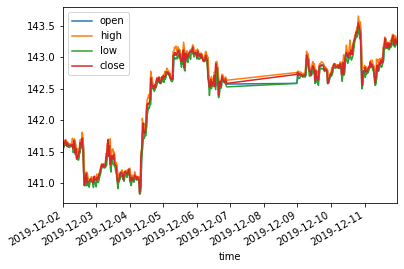

In [10]:
df.plot()

In [11]:
adfuller(df['open'])

(-1.2799512009361274,
 0.6382940264272727,
 0,
 380,
 {'1%': -3.4476763783532585,
  '5%': -2.869176103659426,
  '10%': -2.570837873961219},
 -666.0958845354403)

In [12]:
dfpct = df.pct_change().dropna()
dfpct.describe()

,open,high,low,close
count,380.000000,380.000000,380.000000,380.000000
mean,0.000034,0.000031,0.000034,0.000031
std,0.000669,0.000599,0.000575,0.000666
min,-0.002903,-0.002748,-0.003287,-0.002910
25%,-0.000231,-0.000189,-0.000150,-0.000225
50%,0.000035,0.000007,0.000035,0.000035
75%,0.000306,0.000232,0.000262,0.000304
max,0.003306,0.003717,0.003165,0.003306


In [13]:
adfuller(dfpct['open'])

(-11.213717438022156,
 2.094668054640084e-20,
 3,
 376,
 {'1%': -3.4478619826418817,
  '5%': -2.869257669826291,
  '10%': -2.570881358363513},
 -4252.516004107627)

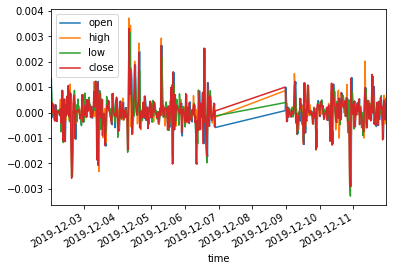

In [14]:
dfpct.plot()